<p style="color: green; font-size:28px; font-family:Georgia;">
AILA (Artificially Intelligent Laboratory Assistant)
</p>

AILA autonomously manages **Atomic Force Microscope (AFM)** imaging and analysis using a sophisticated combination of **large language models (LLMs)** and specially designed tools. The system is compatible with various AFM instruments, including **DriveAFM by Nanosurf**, enabling seamless image optimization and capturing through a **Python-based API**.

Overall, AILA represents a significant leap in laboratory automation, enabling **precise, reliable, and efficient AFM operations** with minimal human intervention.

**AILA (Artificially Intelligent Laboratory Assistant)** is an advanced multi-agent system developed by the NT(M3)RG lab—a collaboration between the **Multiphysics & Multiscale Mechanics Research Group** (M3RG) and the **Nanoscale Tribology, Mechanics & Microscopy of Materials** (NTM3) Group—at the **Indian Institute of Technology Delhi**. 

## Imports

In [7]:
import getpass
import os
import functools
import operator
import glob
#import nanosurf
import time
import numpy as np
import matplotlib.pyplot as plt
from langchain_chroma import Chroma
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import tool
from NSFopen.read import read
# from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.optimize import curve_fit
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from typing import Sequence, TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

import os
from dotenv import load_dotenv


## Setup LLM

In [9]:
load_dotenv()
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.0, max_tokens=1000)

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
)

## Tools

### Document retriever tool

In [10]:
db_new = Chroma(persist_directory="./aila_db2", embedding_function=embeddings)

retriever_wo = db_new.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

⚠️ It looks like you upgraded from a version below 0.5.6 and could benefit from vacuuming your database. Run chromadb utils vacuum --help for more information.
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [11]:
Document_Retriever = create_retriever_tool(
    retriever_wo,
    "Document_Retriever",
    "This tool offers reference code specifically designed for "
    "managing an AFM (Atomic Force Microscope) machine, which is connected to a database. "
    "The tool also includes the AFM software manual for guidance."
    "However, it does not contain any code related to displaying/optimizing images."
    "Single query allowed at one. but multiple call allowed",
)


In [26]:
# Document_Retriever.invoke("p gain")

### Code executor tool

In [13]:
@tool
def Code_Executor(code: str) -> int:
    "Use this tool only to run Python code for operating an Atomic Force Microscope."
    "Use code from 'Document_Retriever' and correct it as needed. This code controls the AFM, so handle it with care."
    try:
        # Execute the code
        import pythoncom
        pythoncom.CoInitialize()
        exec(code)
        output='code executed successfully'
    except Exception as e:
        print("An error occurred during code execution:", e) 
        output=e
    return output


### Image analyzer tool

In [14]:
@tool
def Image_Analyzer(path: str = None, filename: str = None, dynamic_code: str = None, calculate_friction: bool = False, calculate_mean_roughness: bool = False, calculate_rms_roughness: bool = False):
    """
    Display and return the image data from the given path. If a filename is provided, return the image data
    from that specific file. If no filename is provided, return the image data from the latest image file
    in the directory. If dynamic_code is provided, it will be executed to process the image data.
    
    Additionally, calculate the following if requested:
    - Average Friction
    - Mean Roughness
    - RMS Roughness

    Args:
    - path (str): The directory path to search for the latest file. Defaults to None.
    - filename (str): The specific image file to display. Defaults to None.
    - dynamic_code (str): A string containing Python code to process the image data. Defaults to None.
    - calculate_friction (bool): Whether to calculate average friction. Defaults to False.
    - calculate_mean_roughness (bool): Whether to calculate mean roughness. Defaults to False.
    - calculate_rms_roughness (bool): Whether to calculate RMS roughness. Defaults to False.

    Returns:
    - dict: A dictionary containing the status, image data, or an error message.
    """
    if path is None:
        path = os.getcwd()
    
    # Determine the file to display
    if filename:
        file_to_display = os.path.join(path, filename)
        if not os.path.isfile(file_to_display):
            print(f"File not found: {file_to_display}")
            return {"status": "Error", "message": "The specified file does not exist."}
    else:
        # Get the list of all files in the directory
        list_of_files = glob.glob(os.path.join(path, '*'))
        
        if not list_of_files:
            print("No files found in the specified directory.")
            return {"status": "Error", "message": "No files found in the directory."}
        
        # Find the latest file based on creation time
        file_to_display = max(list_of_files, key=os.path.getctime)
    
    print(f"File to display: {file_to_display}")

    try:
        # Read the file
        afm = read(file_to_display)
        
        # Extract data and parameters
        data = afm.data  # Raw data
        param = afm.param  # Parameters
        
        # Assuming 'Image', 'Forward', and 'Z-Axis' are keys in the data structure
        image_data = data['Image']['Forward']['Z-Axis']
        
        # If dynamic code is provided, execute it. image_data = data['Image']['Forward']['Z-Axis'] cange Forward to Backward if asked. Z-Axis to Deflection or Friction force if asked. 
        if dynamic_code:
            # Safely execute the dynamic code
            try:
                exec(dynamic_code)
                # After executing the dynamic code, `image_data` should be processed accordingly
                print("Dynamic code executed successfully.")
            except Exception as e:
                print(f"Error executing dynamic code: {e}")
                return {"status": "Error", "message": f"Error executing dynamic code: {str(e)}"}
        
        # Calculate Average Friction if requested
        if calculate_friction:
            friction = 0.5 * (data['Image']['Forward']['Friction force'] - data['Image']['Backward']['Friction force'])
            average_friction = np.mean(friction)
            print(f"Average Friction: {average_friction}")
        
        # Calculate Mean Roughness if requested
        if calculate_mean_roughness:
            z = data['Image']['Forward']['Z-Axis']
            z_mean = np.mean(z)
            absolute_differences = np.abs(z - z_mean)
            total_sum = np.sum(absolute_differences)
            M, N = z.shape
            mean_roughness = total_sum / (M * N)
            print(f"Mean Roughness: {mean_roughness}")
        
        # Calculate RMS Roughness if requested
        if calculate_rms_roughness:
            z = data['Image']['Forward']['Z-Axis']
            z_mean = np.mean(z)
            squared_differences = (z - z_mean) ** 2
            total_sum = np.sum(squared_differences)
            M, N = z.shape
            rms_roughness = np.sqrt(total_sum / (M * N))
            print(f"RMS Roughness: {rms_roughness}")
        
        # Return the image data along with status
        result = {"status": "Success", "message": f"Raw Image {file_to_display} processed successfully.", "image_data": image_data}
        
        # Include calculated metrics in the result if they were calculated
        if calculate_friction:
            result["average_friction"] = average_friction
        if calculate_mean_roughness:
            result["mean_roughness"] = mean_roughness
        if calculate_rms_roughness:
            result["rms_roughness"] = rms_roughness
        
        return result
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return {"status": "Error", "message": f"An error occurred: {str(e)}"}

### Image optimizer tool

In [15]:
def scan_image(PGain, IGain, DGain, file):
    spm = nanosurf.SPM()
    application = spm.application
    scan = application.Scan
    zcontrol = application.ZController
    
    application.SetGalleryHistoryFilenameMask(file)
    zcontrol.PGain = PGain
    zcontrol.IGain = IGain
    zcontrol.DGain = DGain
    scan.StartFrameUp()
    
    scanning = scan.IsScanning
    while scanning:
        print("Scanning in progress...")
        time.sleep(5)
        scanning = scan.IsScanning

    from NSFopen.read import read
    list_of_files = glob.glob(new_path+'/*')
    latest_file = max(list_of_files, key=os.path.getctime)
    afm = read(latest_file)
    data = afm.data
    im_file_fw = data['Image']['Forward']['Z-Axis']
    im_file_bw = data['Image']['Backward']['Z-Axis']
    similarity_index, diff = ssim(im_file_bw, im_file_fw, full=True, data_range=im_file_bw.max() - im_file_bw.min())
    mse = mean_squared_error(im_file_bw, im_file_fw)
    del spm
    return similarity_index, mse

def corrected_image(image):
    def poly5d(xy, *params):
        x, y = xy
        return (params[0] + params[1]*x + params[2]*y + 
                params[3]*x**2 + params[4]*y**2 + 
                params[5]*x*y + params[6]*x**3 + params[7]*y**3 +
                params[8]*x**2*y + params[9]*x*y**2 + 
                params[10]*x**4 + params[11]*y**4 + 
                params[12]*x**3*y + params[13]*x*y**3 +
                params[14]*x**2*y**2)

    x = np.arange(image.shape[1])
    y = np.arange(image.shape[0])
    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    image_flat = image.flatten()
    params, _ = curve_fit(poly5d, (x, y), image_flat, p0=np.zeros(15))
    baseline = poly5d((x, y), *params).reshape(image.shape)
    corrected_image = image - baseline
    return corrected_image

def scan_image_poly(PGain, IGain, DGain, file):
    spm = nanosurf.SPM()
    application = spm.application
    scan = application.Scan
    zcontrol = application.ZController
    
    application.SetGalleryHistoryFilenameMask(file)
    zcontrol.PGain = PGain
    zcontrol.IGain = IGain
    zcontrol.DGain = DGain
    scan.StartFrameUp()
    
    scanning = scan.IsScanning
    while scanning:
        print("Scanning in progress...")
        time.sleep(5)
        scanning = scan.IsScanning

    from NSFopen.read import read
    list_of_files = glob.glob(new_path+'/*')
    latest_file = max(list_of_files, key=os.path.getctime)
    afm = read(latest_file)
    data = afm.data
    im_file_fw = corrected_image(data['Image']['Forward']['Z-Axis'])
    im_file_bw = corrected_image(data['Image']['Backward']['Z-Axis'])
    similarity_index, diff = ssim(im_file_bw, im_file_fw, full=True, data_range=im_file_bw.max() - im_file_bw.min())
    mse = mean_squared_error(im_file_bw, im_file_fw)
    del spm
    return similarity_index, mse

class MyProblem(ElementwiseProblem):
    def __init__(self, baseline=True):
        super().__init__(n_var=3,
                         n_obj=1,
                         xl=np.array([0, 500, 0]),
                         xu=np.array([500, 9000, 100]))
        self.baseline = baseline

    def _evaluate(self, x, out, *args, **kwargs):
        if self.baseline:
            scan_outputs = scan_image_poly(x[0], x[1], x[2], f"scan_{x[0]}_{x[1]}_{x[2]}_")
        else:
            scan_outputs = scan_image(x[0], x[1], x[2], f"scan_{x[0]}_{x[1]}_{x[2]}_")

        mse = scan_outputs[1]
        f1 = (1 - mse) * 10000
        out["F"] = [f1]
# Save the current working directory
original_path = os.getcwd()

# Specify the new path you want to temporarily switch to
new_path = '/Users/Admin/AppData/Local/Nanosurf/Nanosurf CX/AI-Optimization'


@tool
def Image_optimizer(baseline: bool) -> str:
    """This tool optimizes the parameters (P/I/D gains) based on baseline correction
    settings to provide the best solution for image clarity. Use this tool if the image 
    appears blurry or unclear and you want to enhance its sharpness."""

    try:
        os.chdir(new_path)
        print(f"Current working directory: {os.getcwd()}")
        
        # Your code that needs to be executed in the new directory goes here
        import pythoncom
        pythoncom.CoInitialize()
    
        list_of_files = glob.glob(new_path+'/*') 
        latest_file = max(list_of_files, key=os.path.getctime)
        print(latest_file)
    
    
        problem = MyProblem(baseline=baseline)
    
        termination = get_termination("n_gen", 2)
        algorithm = GA(pop_size=2, eliminate_duplicates=True)
    
        res = minimize(problem,
                       algorithm,
                       termination,
                       seed=1,
                       verbose=True)

    finally:
        # Restore the original working directory
        os.chdir(original_path)
        print(f"Returned to original working directory: {os.getcwd()}")

    return "Best solution found: \n[Pgain Igain Dgain] = %s\n[Error] = %s" % (res.X, res.F)

## Agents

In [16]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an advanced AI-AFM system with access to the Nanosurf AFM software through its Python API."
                "You can execute specific Python code to control and manage the AFM instrument. Collaboration with other assistants is encouraged."
                "Use the available tools to make progress towards answering the question."
                "If you are unable to provide a complete answer, prefix your response with NEED HELP so another assistant can continue where you left off."
                "If you or another assistant have the final answer or deliverable, prefix your response with FINAL ANSWER to indicate that no further action is needed."
                "You have access to the following tools: {tool_names}. \n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message) ##used to input {system_message}
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools])) ##used to input {tool_names}
    return prompt | llm.bind_tools(tools)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    # convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name
    }


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    sender: str


## AILA

In [17]:
def create_AILA_agent(llm, tools, system_message: str):
    """Create an agent."""
    options = ["FINISH"] + tools
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                "Given the conversation above, who should act next?"
                "The AFM_Handler is exclusively for capturing images and controlling the AFM machine; it cannot handle image after-processing"
                "Or should we FINISH? Select one of: {options}.\n{system_message}.",
                # "only type the one of: {options}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message) ##used to input {system_message}
    # prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools])) ##used to input {tool_names}
    prompt = prompt.partial(options=str(options), team_members=", ".join(tools))
    return prompt | llm


## Graph

### Tools

In [18]:
from langgraph.prebuilt import ToolNode

afm_handler_tools = [Document_Retriever, Code_Executor]
afm_handler_tools_node = ToolNode(afm_handler_tools)
data_handler_tools = [Image_Analyzer, Image_optimizer]
data_handler_tools_node = ToolNode(data_handler_tools)

### Agents

In [19]:
afm_handler_agent = create_agent(
    llm, 
    [Document_Retriever, Code_Executor], 
   "You will have access to a database of relevant codes for setting AFM parameters, scanning images, and approaching the tip through the 'Document_Retriever' tool."
    "Gather Codes: Retrieve the necessary codes from the database for configuring parameters and performing scans."
    "Modification and Execution: Modify the retrieved codes as needed (do not write new code to avoid potential damage to the AFM) and execute them using the 'Code_Executor' tool."
    "Steps for Capturing an Image: 1. Set the required parameters using the retrieved codes. 2.Approach the tip if directed to do so. 3. Finally, perform the scan according to the modified code."
    "Ensure to follow these steps accurately for successful image capture." ,
)

afm_handler_node = functools.partial(agent_node, agent=afm_handler_agent, name="AFM_Handler")

data_handler_agent = create_agent(
    llm,[Image_Analyzer, Image_optimizer], 
    "You have access to two tools: 'Image_Analyzer': Use this tool to plot and analyze images stored on the system." 
    "You can retrieve raw image data from this tool for further processing. Other assistants may save images to the system."
    "'Image_Optimizer': This tool is used to enhance image quality, including improving line clarity and sharpness. If the feature size in the image is very small, set the baseline parameter to true for better results."
    "Utilize these tools as follows: Analyze and retrieve raw image data using 'Image_Analyzer'."
    "Optimize the image quality using 'Image_Optimizer', applying the baseline parameter if necessary. Follow these steps to ensure high-quality image processing and analysis.",
)
data_handler_node = functools.partial(agent_node, agent=data_handler_agent, name="Data_Handler")

# members=["AFM_Handler", "Data_Handler"]

AILA_main = create_AILA_agent(
    llm,
    ["AFM_Handler", "Data_Handler"],
    '''You are AILA (Artificially Intelligent Laboratory Assistant), 
    an advanced multi-agent AI-AFM system developed by the NT(M3)RG lab,
    a collaboration between the Multiphysics & Multiscale Mechanics Research Group (M3RG)
    and the Nanoscale Tribology, Mechanics & Microscopy of Materials (NTM3) Group
    at the Indian Institute of Technology Delhi.
    Your role is to manage the conversation among the following team members: {team_members}.
    Based on the user's request, identify the appropriate worker to act next.
    Each worker will complete their assigned task and provide their results and status.
    When all tasks are completed, respond with FINISH.'''
)
AILA_main_node = functools.partial(agent_node, agent=AILA_main , name="AILA")


### Conditions

In [20]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "tool_calls" not in last_message.additional_kwargs:
        if "NEED HELP" in last_message.content:
            return "go"
        elif "FINAL ANSWER" in last_message.content:
            return "__end__"
        return "__end__"
    # Otherwise if there is, we continue
    else:
        return "continue"


def AILA_output(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    # if "tool_calls" not in last_message.additional_kwargs:
    #     return "__end__"
    # Otherwise if there is, we continue
    if "AFM_Handler" in last_message.content:
            return "AH"
    elif "Data_Handler" in last_message.content:
            return "DH"
    else:
        return "__end__"

### Connections

In [21]:
workflow = StateGraph(AgentState)
workflow.add_node("AFM_Handler", afm_handler_node)
workflow.add_node("AFM_Handler_Tools", afm_handler_tools_node)
workflow.add_node("Data_Handler", data_handler_node)
workflow.add_node("Data_Handler_Tools", data_handler_tools_node)
workflow.add_node("AILA", AILA_main_node)


# In[17]:


workflow.add_conditional_edges(
    "AILA",
    AILA_output,
    {"AH": "AFM_Handler","DH": "Data_Handler","__end__": END}, 
)

workflow.add_conditional_edges(
    "AFM_Handler",
    should_continue,
    {"continue": "AFM_Handler_Tools","go": "Data_Handler","__end__": END}, 
)

workflow.add_conditional_edges(
    "Data_Handler",
    should_continue,
    {"continue": "Data_Handler_Tools","go": "AFM_Handler","__end__": END},
)

workflow.add_edge("AFM_Handler_Tools", "AFM_Handler")
workflow.add_edge("Data_Handler_Tools", "Data_Handler")
workflow.add_edge(START, "AILA")

graph = workflow.compile()


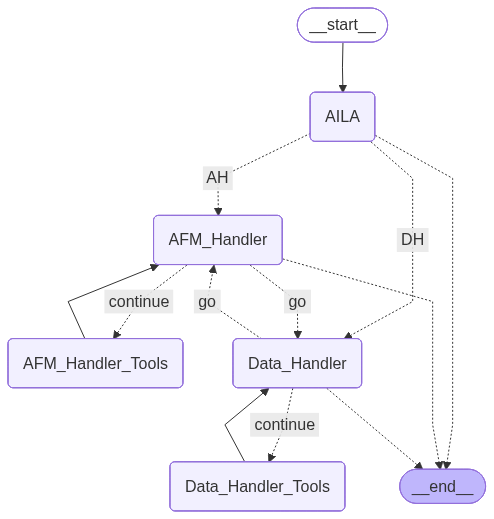

In [22]:

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Prompt

In [25]:
from langchain_core.runnables.config import RunnableConfig
config = RunnableConfig(recursion_limit=40)


# In[20]:


def print_stream(stream):
    count=-1
    for s in stream:
        count=count+1
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
            
    print("total steps:",count)


# In[24]:

start_time = time.time()
recursion_limit=30
inputs = {"messages": [("user", "What is your name?")]} ###enter input
print_stream(graph.stream(inputs, stream_mode="values",  config= config))


end_time = time.time()
duration = end_time - start_time
print(f"\nTotal time taken: {duration:.2f} seconds")

('user', 'What is your name?')
================================== Ai Message ==================================
Name: AILA

I am AILA, the Artificially Intelligent Laboratory Assistant. How can I assist you today?
total steps: 1

Total time taken: 2.21 seconds
